In [ ]:
# pip install skforecast

In [ ]:
# pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
# Crear una sesión de Spark
spark = SparkSession.builder.appName("CargarDatosLimpios").getOrCreate()

# Ruta donde se guardó el DataFrame
ruta_guardado = "/home/jovyan/work/data/processed/df_marbella_daily_cleaned.csv"

# Leer el archivo CSV guardado
df = spark.read.csv(ruta_guardado, header=True, inferSchema=True)

In [3]:
# Mostrar el esquema y algunas filas para verificar
df.printSchema()
df.show(5)

root
 |-- fecha: date (nullable = true)
 |-- tmed: double (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- hrMedia: double (nullable = true)

+----------+------------------+-----------------+------------------+-------+
|     fecha|              tmed|             tmin|              tmax|hrMedia|
+----------+------------------+-----------------+------------------+-------+
|2019-01-01|13.899999618530273|9.600000381469727|18.200000762939453|   63.0|
|2019-01-02|14.600000381469727|9.399999618530273|19.899999618530273|   56.0|
|2019-01-03|13.100000381469727|9.600000381469727|16.600000381469727|   70.0|
|2019-01-04|12.699999809265137|9.300000190734863|16.100000381469727|   69.0|
|2019-01-05|12.399999618530273|7.900000095367432|              17.0|   67.0|
+----------+------------------+-----------------+------------------+-------+
only showing top 5 rows



In [4]:
df = df.toPandas()
df_pandas = df.copy()

In [5]:
df_pandas.isna().sum()

fecha      0
tmed       0
tmin       0
tmax       0
hrMedia    0
dtype: int64

In [7]:
df_pandas.describe()

,tmed,tmin,tmax,hrMedia
count,2199.000000,2199.000000,2199.000000,2199.000000
mean,18.927581,15.851728,22.004047,69.545020
std,4.068957,4.218887,4.177010,12.892025
min,7.800000,5.300000,9.900000,9.000000
25%,15.500000,12.450000,18.600000,64.000000
50%,18.700001,15.600000,21.700001,72.000000
75%,22.250000,19.200001,25.299999,78.000000
max,30.600000,26.600000,37.599998,97.000000


In [8]:
df.head(5)

,fecha,tmed,tmin,tmax,hrMedia
0,2019-01-01,13.9,9.6,18.200001,63.0
1,2019-01-02,14.6,9.4,19.900000,56.0
2,2019-01-03,13.1,9.6,16.600000,70.0
3,2019-01-04,12.7,9.3,16.100000,69.0
4,2019-01-05,12.4,7.9,17.000000,67.0


##### Analisis de la serie temporal

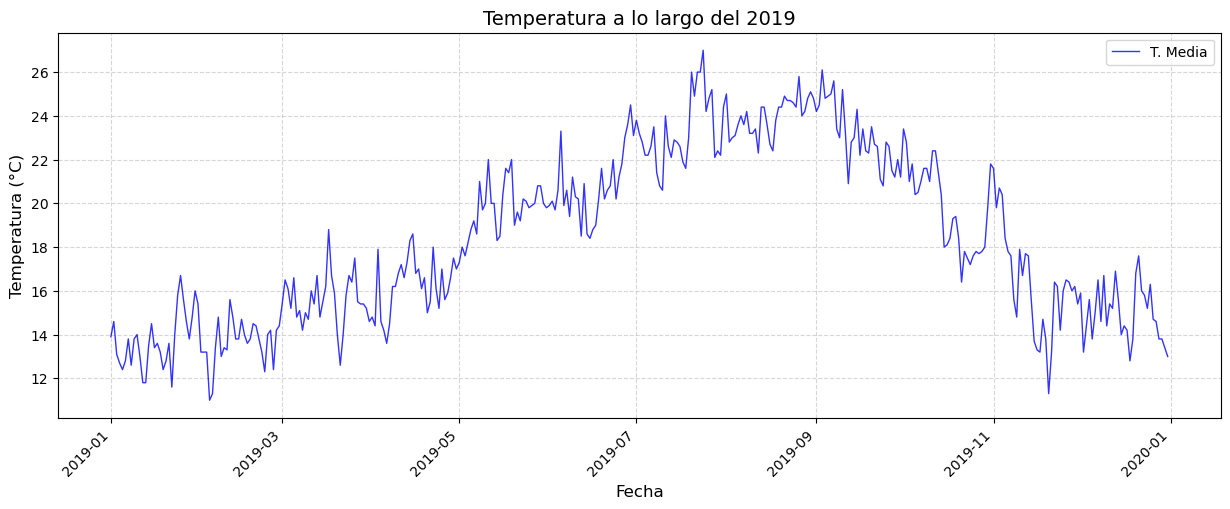

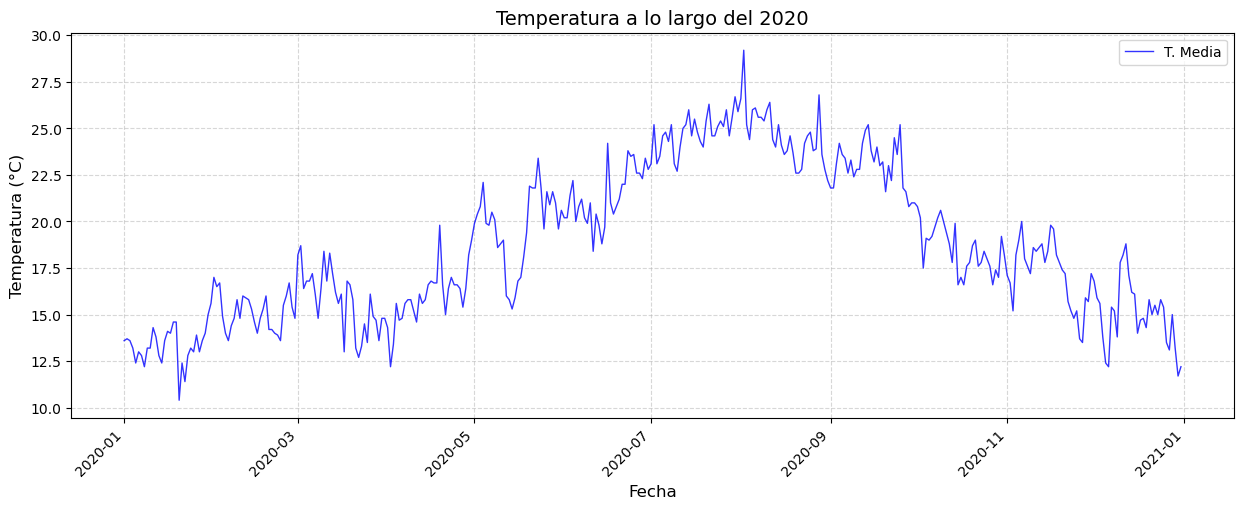

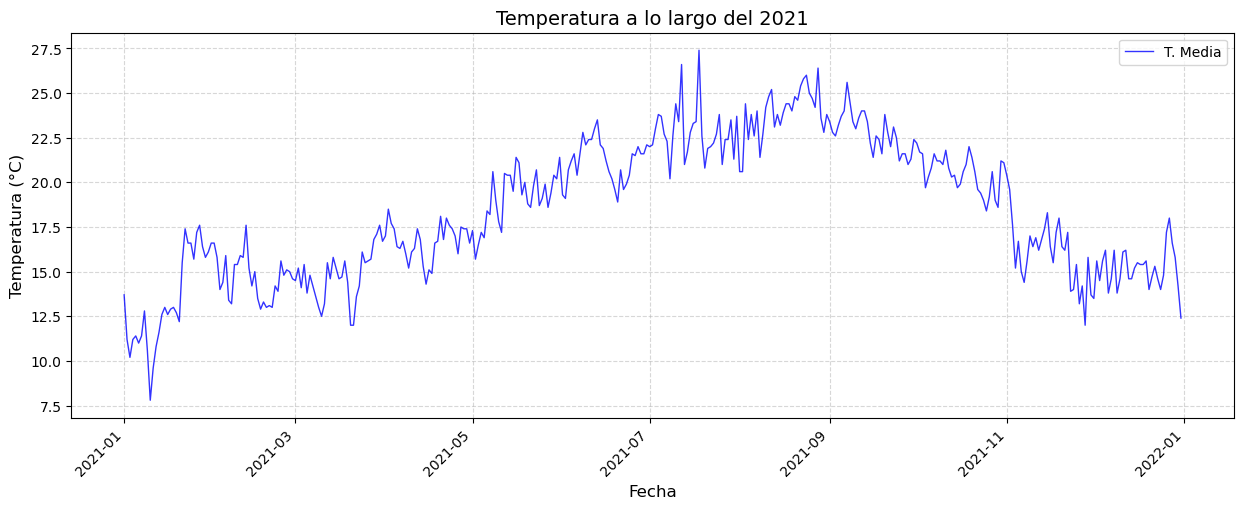

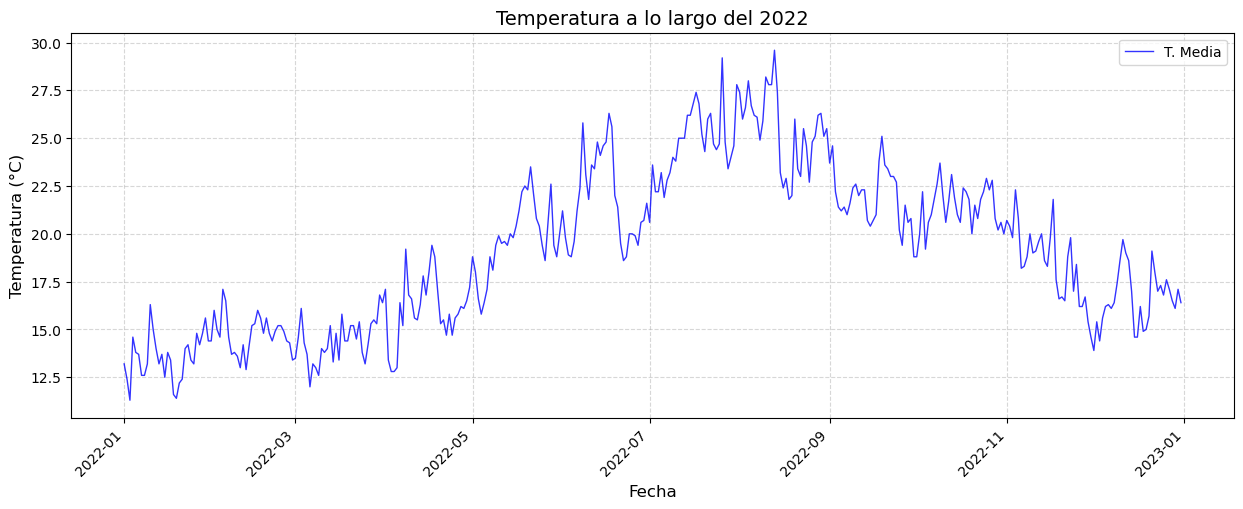

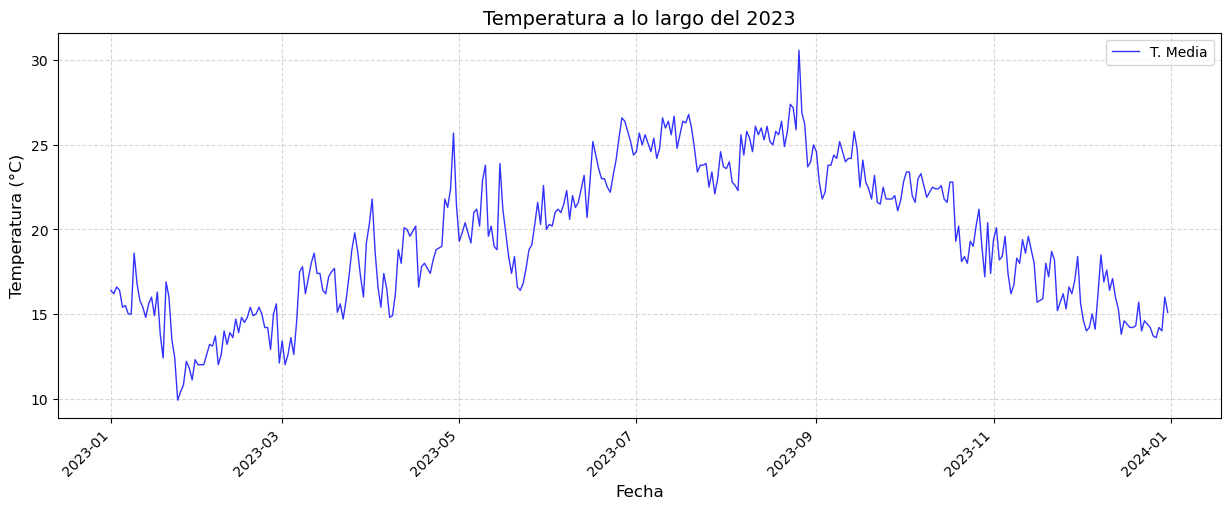

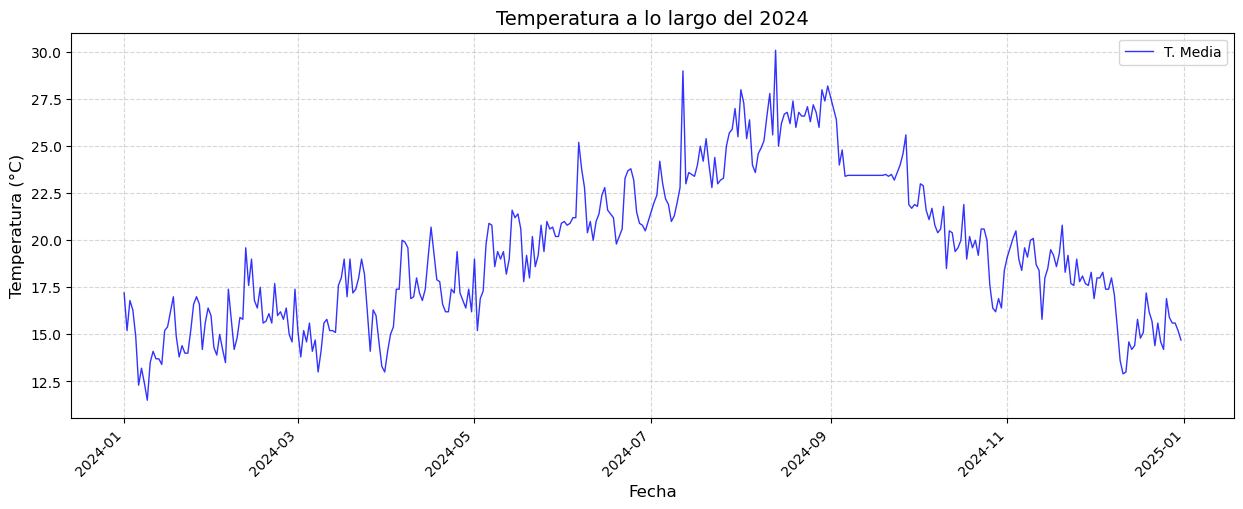

In [9]:
# Convertir la columna 'fecha' a tipo datetime si no lo está
df_pandas['fecha'] = pd.to_datetime(df_pandas['fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='fecha')

# Obtener los años únicos en el DataFrame
años_unicos = df_pandas['fecha'].dt.year.unique()

# Generar un gráfico por cada año
for año in años_unicos[:6]:
    df_anual = df_pandas[df_pandas['fecha'].dt.year == año]
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_anual['fecha'], df_anual['tmed'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='T. Media')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura a lo largo del {año}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.show()

Descomposicion de la serie temporal por sus componentes

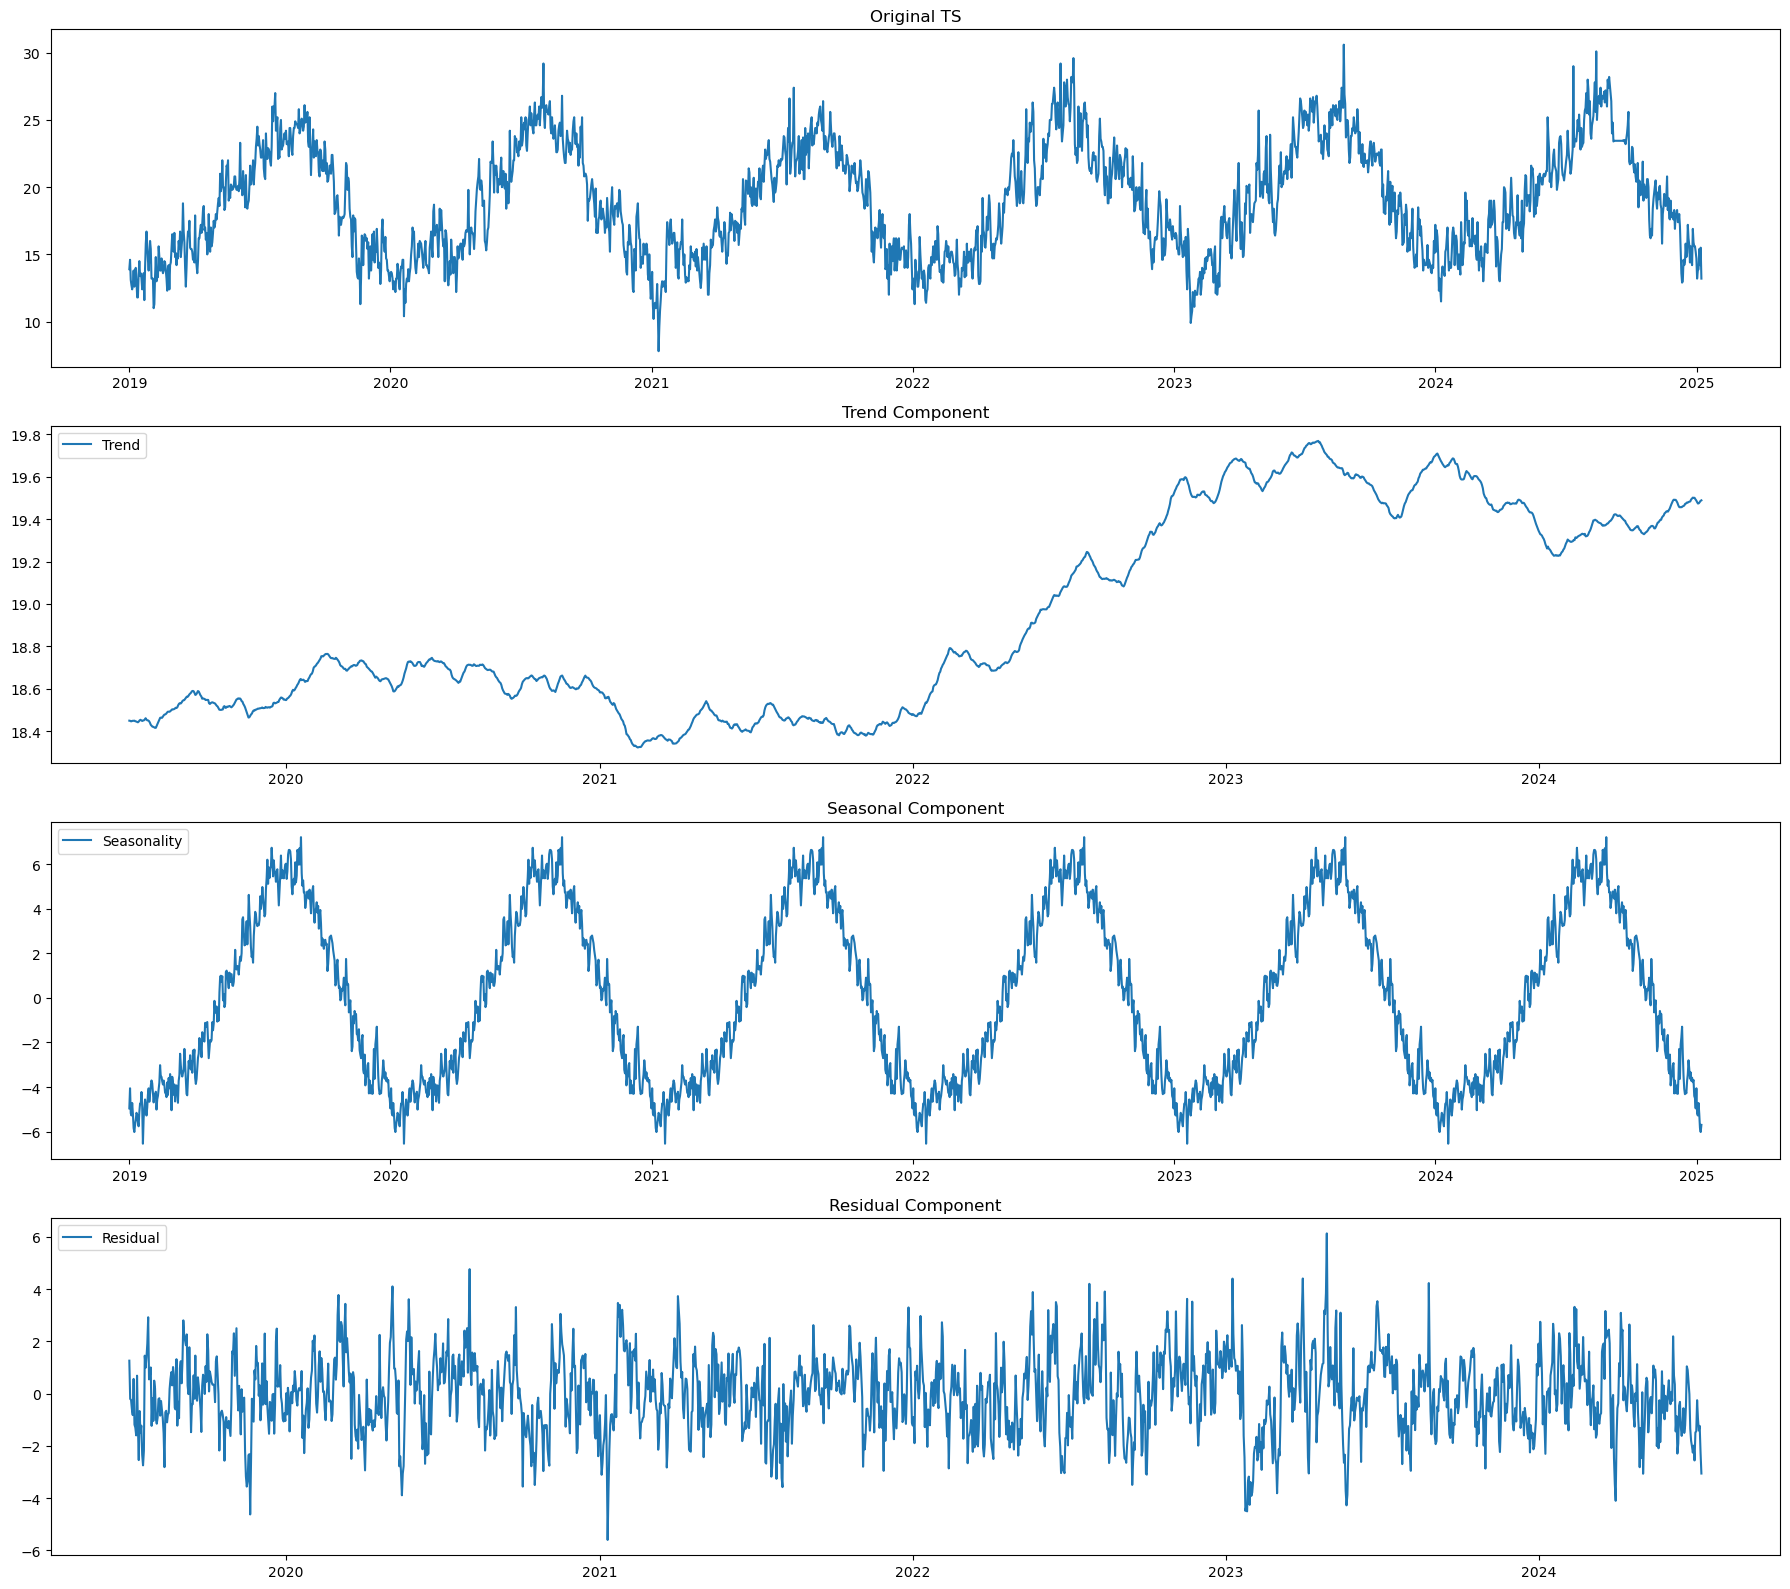

In [10]:
# Decompose the Air Passengers dataset to show trend, seasonality, and residuals
decomposition_air = seasonal_decompose(df_pandas['tmed'], model='additive', period=365)

# Plot the decomposed components for Air Passengers
plt.figure(figsize=(18, 16))

plt.subplot(4, 1, 1)
plt.plot(df_pandas["fecha"], df_pandas["tmed"])
plt.title('Original TS')

plt.subplot(4, 1, 2)
plt.plot(df_pandas["fecha"], decomposition_air.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(df_pandas["fecha"], decomposition_air.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(df_pandas["fecha"], decomposition_air.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


Comprobamos si la serie es estacionaria

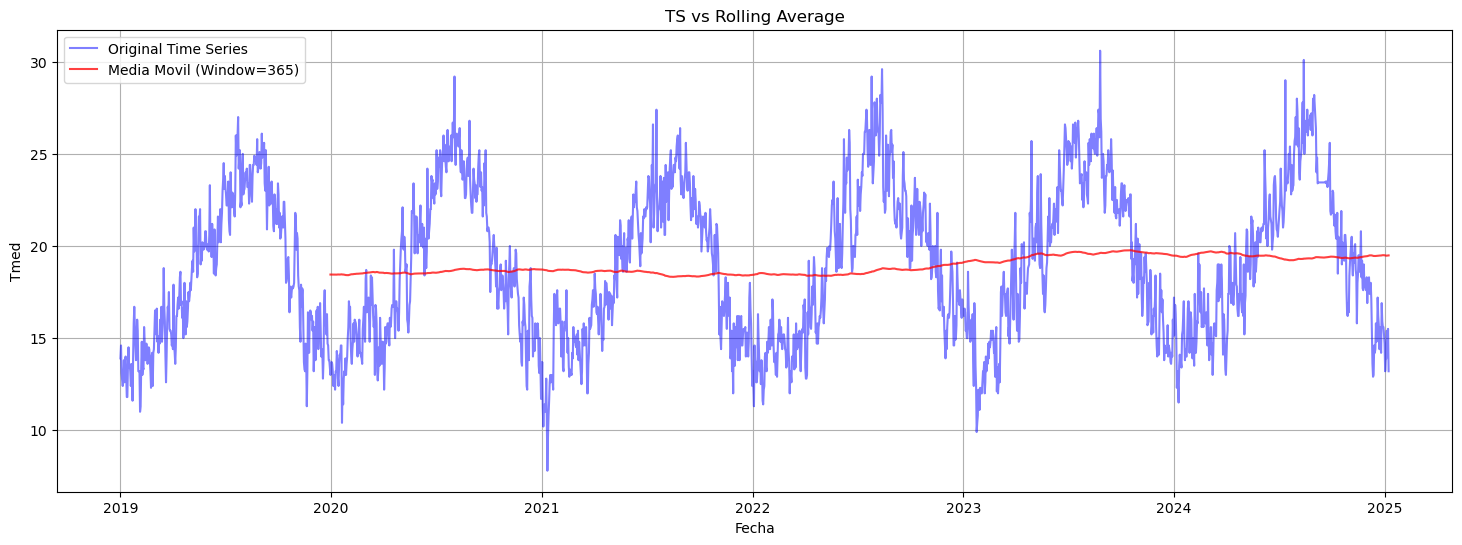

In [11]:
window_size = 365

df_pandas['MA'] = df_pandas["tmed"].rolling(window=window_size).mean()

plt.figure(figsize=(18, 6))

plt.plot(df_pandas["fecha"], df_pandas['tmed'], label='Original Time Series', color='blue', alpha=0.5)
plt.plot(df_pandas["fecha"], df_pandas['MA'], label=f'Media Movil (Window={window_size})', color='red', alpha=0.75)

plt.title('TS vs Rolling Average')
plt.xlabel('Fecha')
plt.ylabel('Tmed')
plt.legend()
plt.grid(True)
plt.show()

Realizamos el test ADF (Augmented Dickey-Fuller) para comprobar si la serie es estacionaria

In [12]:
def check_stationarity(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

In [13]:
check_stationarity(df['tmed'], 'T. media')

ADF Statistic for T. media: -2.7326127348940314
p-value: 0.06856285302446775
The series is likely non-stationary.


Como resultado del test de Dickey-Fuller, observamos que la serie temporal no es estacionaria

Metodo de log para hacer la serie estacionaria

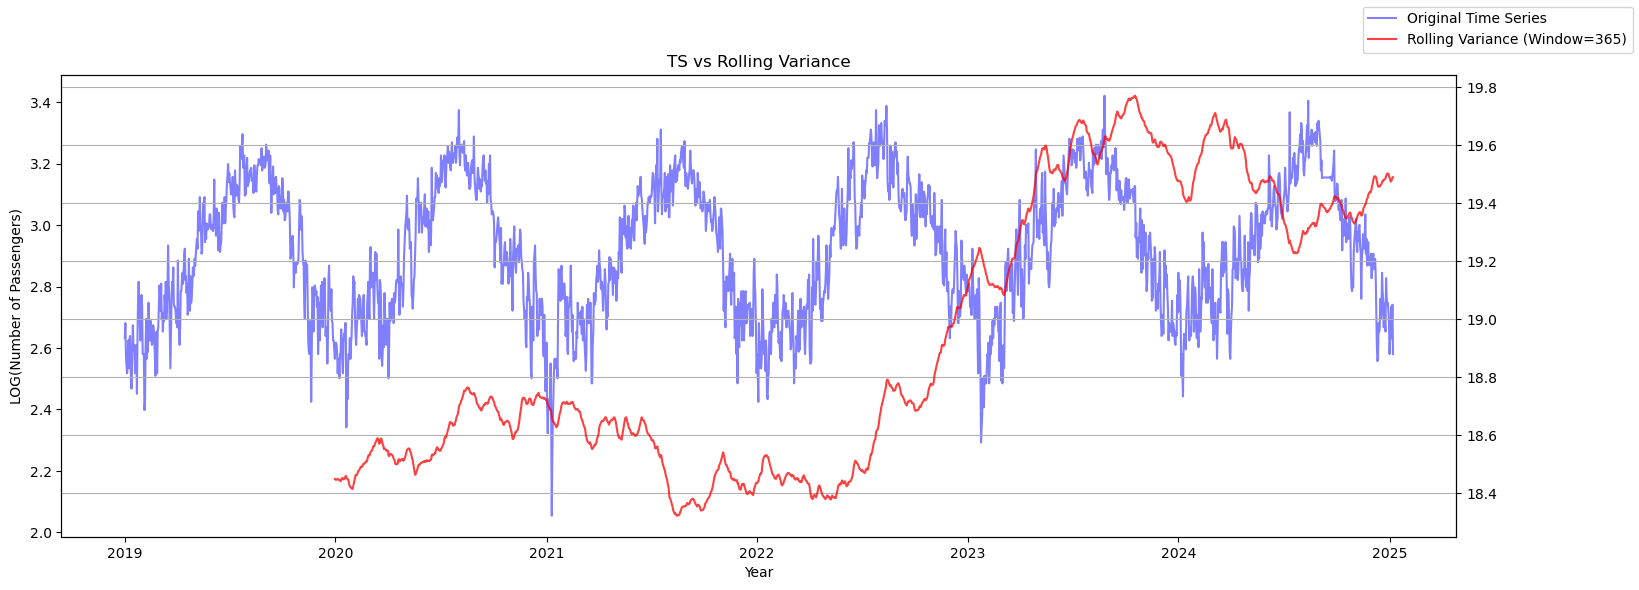

ADF Statistic for Log T. media: -2.892648305313939
p-value: 0.04620960292296292
The series is likely stationary.


In [14]:
fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.plot(df_pandas["fecha"], np.log(df_pandas['tmed']), label='Original Time Series', color='blue', alpha=0.5)

ax2 = ax1.twinx()

ax2.plot(df_pandas["fecha"], df_pandas['MA'], label=f'Rolling Variance (Window={window_size})', color='red', alpha=0.75)

ax1.set_title('TS vs Rolling Variance')
ax1.set_xlabel('Year')
ax1.set_ylabel('LOG(Number of Passengers)')

fig.legend()
plt.grid(True)
plt.show()

check_stationarity(np.log(df['tmed']), 'Log T. media')

Metodo de diferenciacion para hacer la serie estacionaria

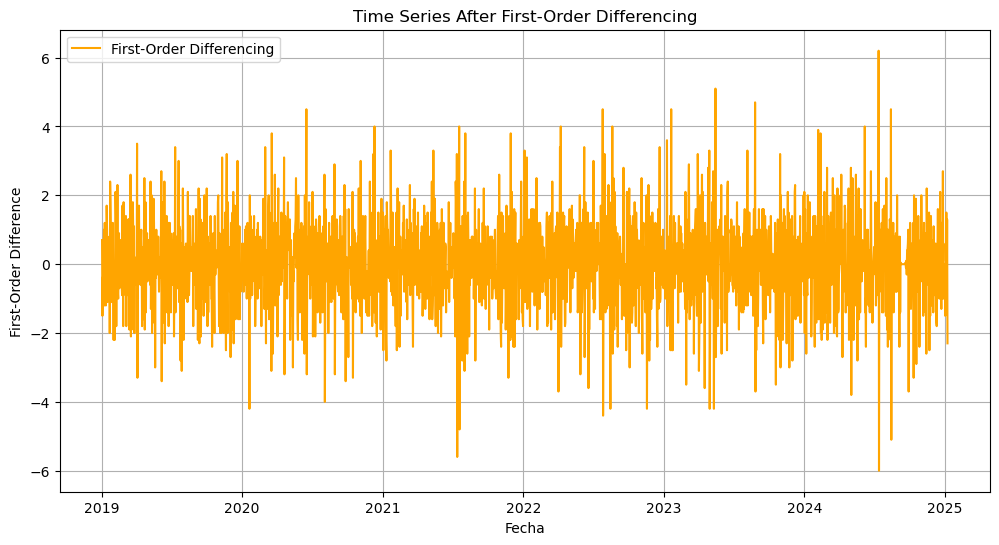

ADF Statistic for First-Order Differenced Series: -16.427595481530968
p-value: 2.4960856814646155e-29
The series is likely stationary.


In [15]:
df_pandas['lag_1'] = df_pandas['tmed'].diff()

plt.figure(figsize=(12, 6))
plt.plot(df_pandas['fecha'], df_pandas['lag_1'], label='First-Order Differencing', color='orange')
plt.title('Time Series After First-Order Differencing')
plt.xlabel('Fecha')
plt.ylabel('First-Order Difference')
plt.legend()
plt.grid(True)
plt.show()

check_stationarity(df_pandas['lag_1'].dropna(), 'First-Order Differenced Series')

##### Deteccion de outliers

In [16]:
from scipy.stats import median_abs_deviation

Moving average y standard deviation (with centered window)

In [21]:
window = 30  # 30 days window
threshold = 2  # Threshold of 2 standard deviations

ma = df_pandas["tmed"].rolling(window=window, center=True).mean()
std = df_pandas["tmed"].rolling(window=window, center=True).std()

#Treshold min and max
threshold_min = ma - std*threshold 
threshold_max = ma + std*threshold 

#Outliers detection
df_pandas["outlier_ma"] = (np.abs(df_pandas["tmed"] - ma) > threshold * std)

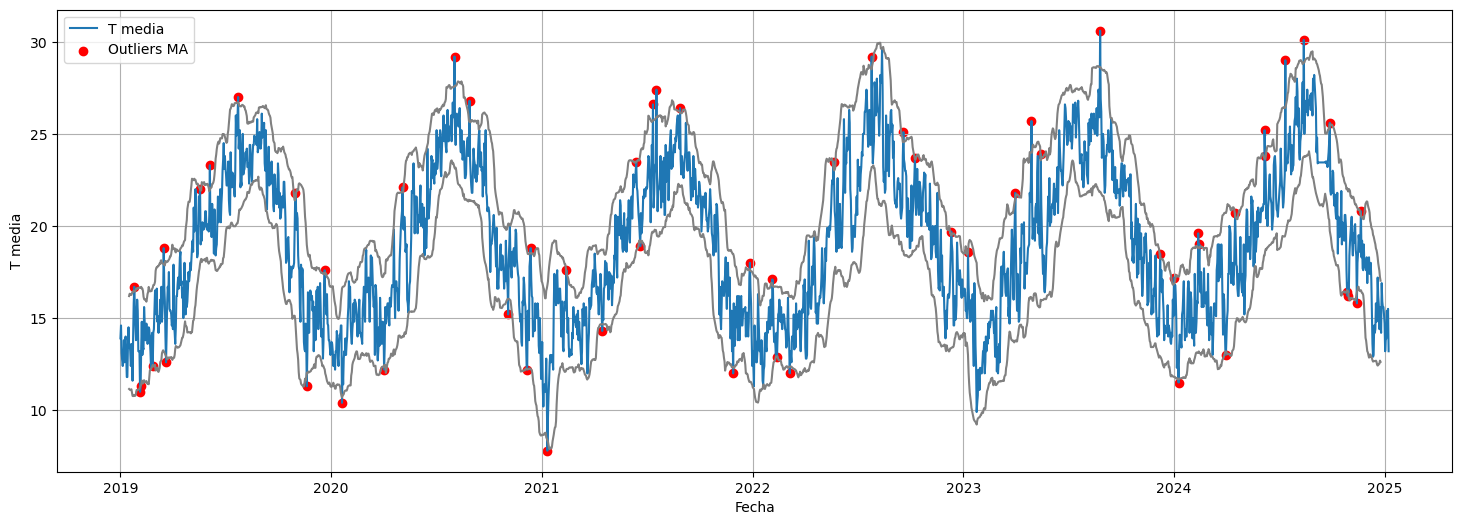

In [22]:
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['fecha'], df_pandas['tmed'], label='T media')
plt.plot(df_pandas['fecha'], threshold_min, color='gray')
plt.plot(df_pandas['fecha'], threshold_max, color='gray')

plt.scatter(df_pandas["fecha"][df_pandas["outlier_ma"]], df_pandas["tmed"][df_pandas["outlier_ma"]], color='red', label="Outliers MA")
plt.xlabel('Fecha')
plt.ylabel('T media')
plt.legend()
plt.grid(True)
plt.show()

Moving average y standard deviation (with left window)

In [23]:
window = 30  # 30 days window
threshold = 2  # Threshold of 2 standard deviations

ma = df_pandas["tmed"].rolling(window=window).mean()
std = df_pandas["tmed"].rolling(window=window).std()

#Treshold min and max
threshold_min = ma - std*threshold 
threshold_max = ma + std*threshold 

#Outliers detection
df_pandas["outlier_ma"] = (np.abs(df_pandas["tmed"] - ma) > threshold * std)

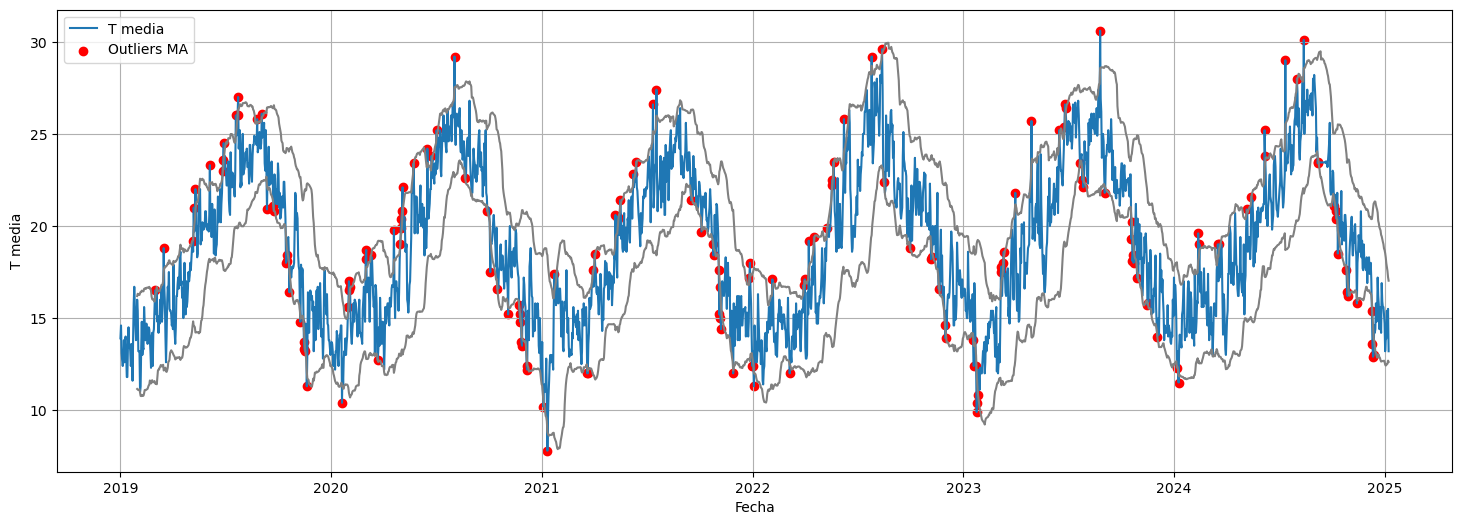

In [24]:
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['fecha'], df_pandas['tmed'], label='T media')
plt.plot(df_pandas['fecha'], threshold_min, color='gray')
plt.plot(df_pandas['fecha'], threshold_max, color='gray')
plt.scatter(df["fecha"][df_pandas["outlier_ma"]], df_pandas["tmed"][df_pandas["outlier_ma"]], color='red', label="Outliers MA")
plt.xlabel('Fecha')
plt.ylabel('T media')
plt.legend()
plt.grid(True)
plt.show()

##### Filtro Hampel (with centered window)

El filtro Hampel es un método utilizado para detectar y eliminar valores atípicos en series temporales. Este filtro es una variación de la regla de tres sigmas en estadística que es robusta frente a valores atípicos.
Funciona calculando la mediana de una ventana que incluye la muestra actual y sus vecinos, generalmente tres muestras por lado.

In [25]:
window_size=30
n_sigma=3

#Calculate the median in a rolling centered window
rolling_median = df_pandas["tmed"].rolling(window_size, center=True).median()

#Calculate the median of the absolute deviations from the data’s median in a rolling centered window
mad = df_pandas["tmed"].rolling(window_size, center=True).apply(median_abs_deviation)

#Treshold 
threshold_min = rolling_median - n_sigma*mad
threshold_max = rolling_median + n_sigma*mad

df_pandas["outlier_hm"] = (np.abs(df_pandas["tmed"] - rolling_median) > n_sigma*mad)

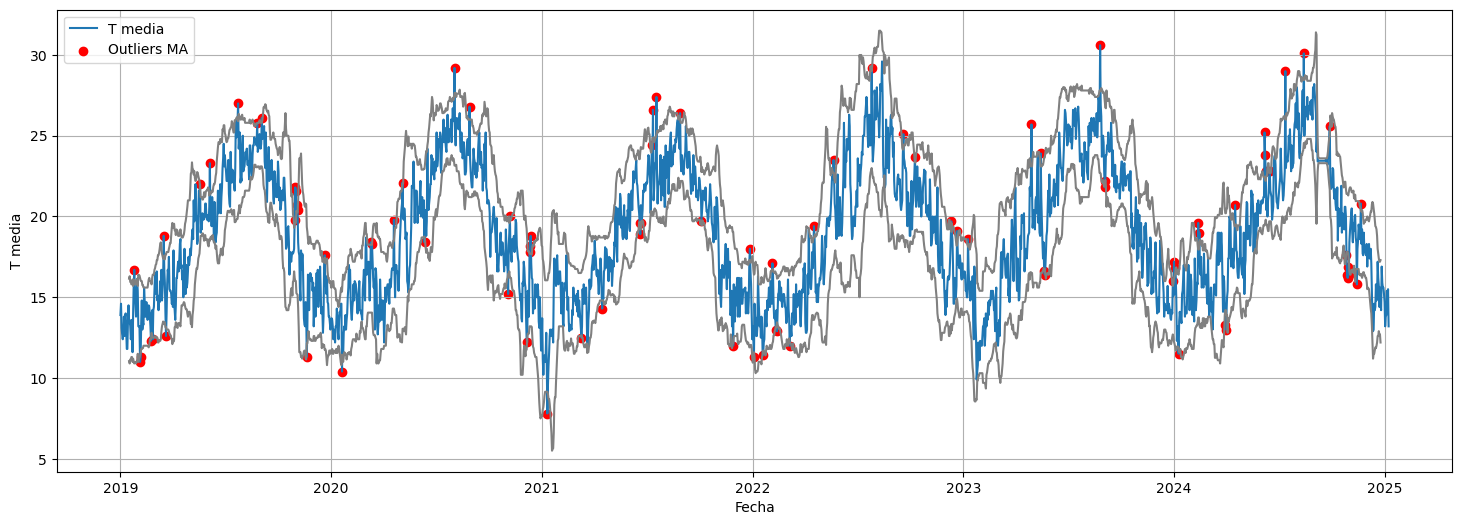

In [26]:
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['fecha'], df_pandas['tmed'], label='T media')
plt.plot(df_pandas['fecha'], threshold_min, color='gray')
plt.plot(df_pandas['fecha'], threshold_max, color='gray')
plt.scatter(df_pandas["fecha"][df_pandas["outlier_hm"]], df_pandas["tmed"][df_pandas["outlier_hm"]], color='red', label="Outliers MA")
plt.xlabel('Fecha')
plt.ylabel('T media')
plt.legend()
plt.grid(True)
plt.show()

Tratamiento de los datos outliers por el valor mas cercano (limite superior o limite inferior segun sea necesario)

In [27]:
df_pandas[df_pandas["outlier_hm"]==True].head()

,fecha,tmed,tmin,tmax,hrMedia,MA,lag_1,outlier_ma,outlier_hm
24,2019-01-25,16.700001,13.0,20.4,76.0,NaN,0.900001,False,True
34,2019-02-04,11.000000,6.8,15.2,56.0,NaN,-2.200000,False,True
35,2019-02-05,11.300000,7.2,15.4,71.0,NaN,0.300000,False,True
53,2019-02-23,12.300000,8.2,16.4,74.0,NaN,-0.900000,False,True
56,2019-02-26,12.400000,9.3,15.6,66.0,NaN,-1.800000,False,True


In [28]:
# Sustituir los outliers por el valor más cercano dentro del rango
df_pandas["tmed_corrected"] = df_pandas["tmed"].copy()
df_pandas.loc[df_pandas["tmed"] < threshold_min, "tmed_corrected"] = threshold_min
df_pandas.loc[df_pandas["tmed"] > threshold_max, "tmed_corrected"] = threshold_max

In [29]:
df_pandas[df_pandas["outlier_hm"]==True].head()

,fecha,tmed,tmin,tmax,hrMedia,MA,lag_1,outlier_ma,outlier_hm,tmed_corrected
24,2019-01-25,16.700001,13.0,20.4,76.0,NaN,0.900001,False,True,16.000000
34,2019-02-04,11.000000,6.8,15.2,56.0,NaN,-2.200000,False,True,11.400000
35,2019-02-05,11.300000,7.2,15.4,71.0,NaN,0.300000,False,True,11.550000
53,2019-02-23,12.300000,8.2,16.4,74.0,NaN,-0.900000,False,True,12.399999
56,2019-02-26,12.400000,9.3,15.6,66.0,NaN,-1.800000,False,True,12.500001


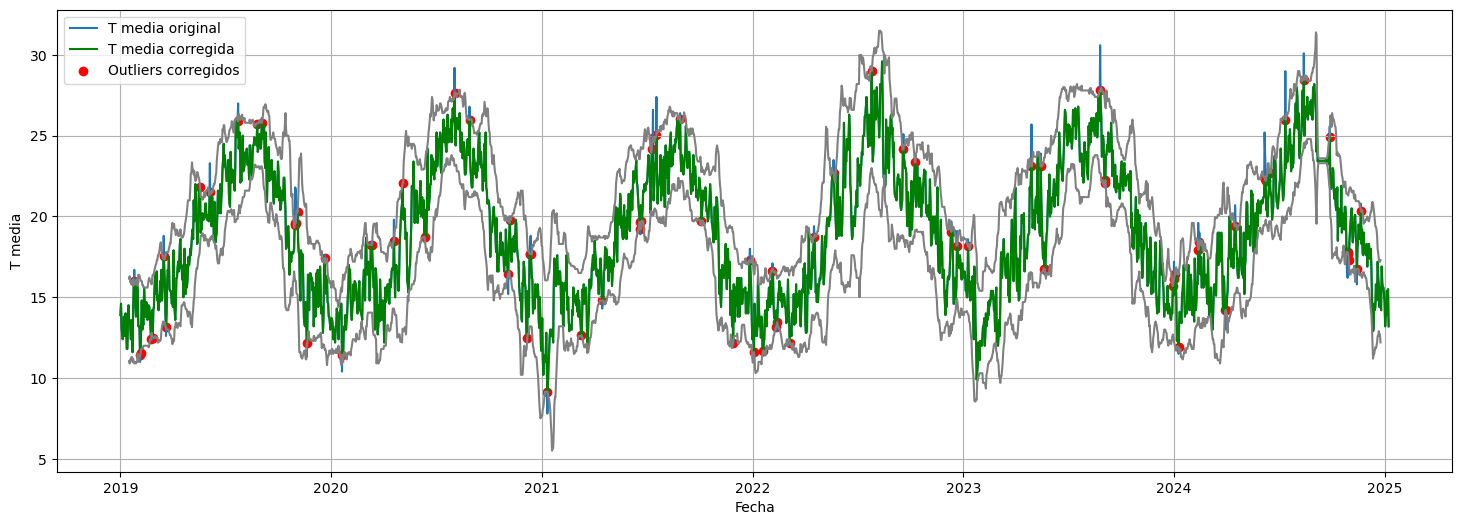

In [30]:
# Graficar los resultados
plt.figure(figsize=(18, 6))

plt.plot(df_pandas['fecha'], df_pandas['tmed'], label='T media original')
plt.plot(df_pandas['fecha'], df_pandas['tmed_corrected'], label='T media corregida', color='green')
plt.plot(df_pandas['fecha'], threshold_min, color='gray')
plt.plot(df_pandas['fecha'], threshold_max, color='gray')
plt.scatter(df_pandas["fecha"][df_pandas["outlier_hm"]], df_pandas["tmed_corrected"][df_pandas["outlier_hm"]], color='red', label="Outliers corregidos")
plt.xlabel('Fecha')
plt.ylabel('T media')
plt.legend()
plt.grid(True)
plt.show()

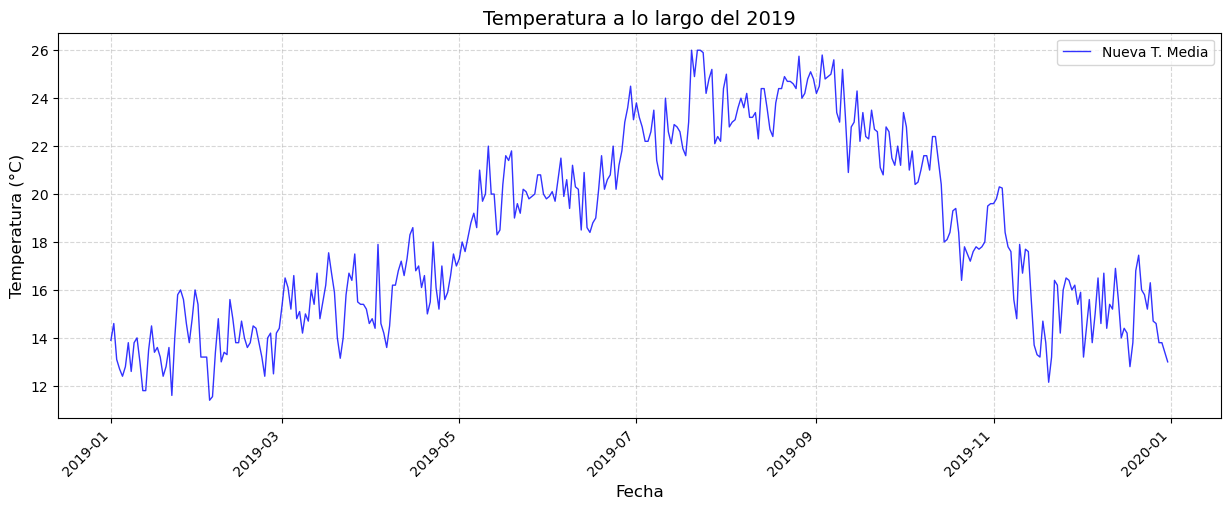

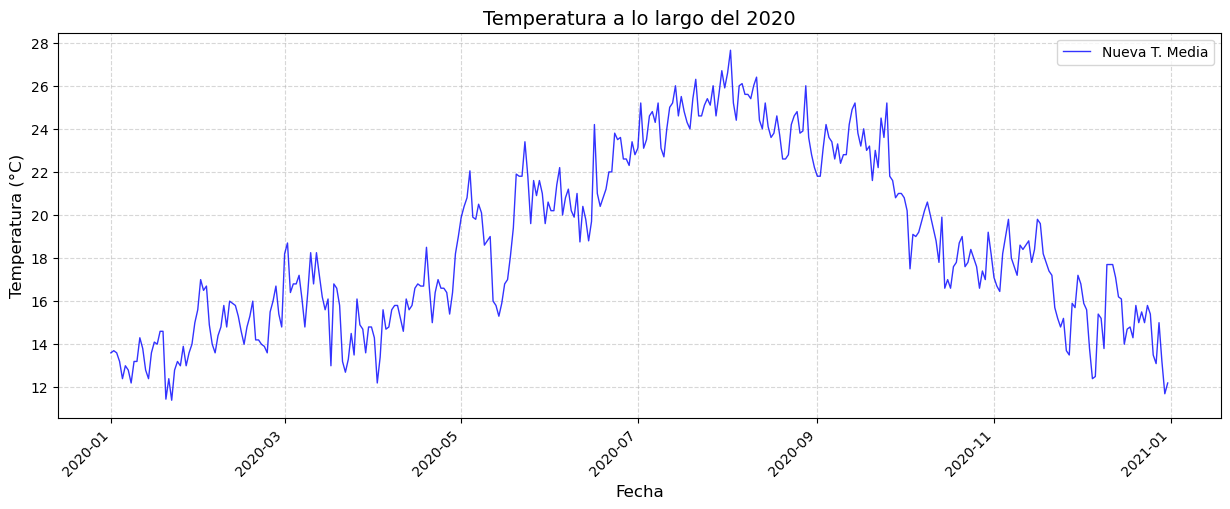

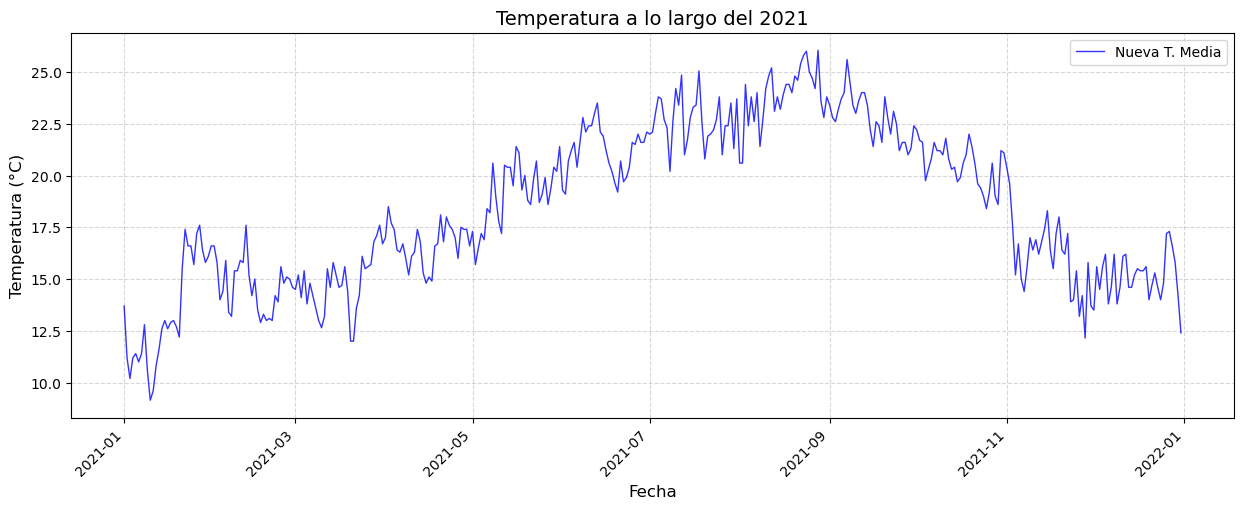

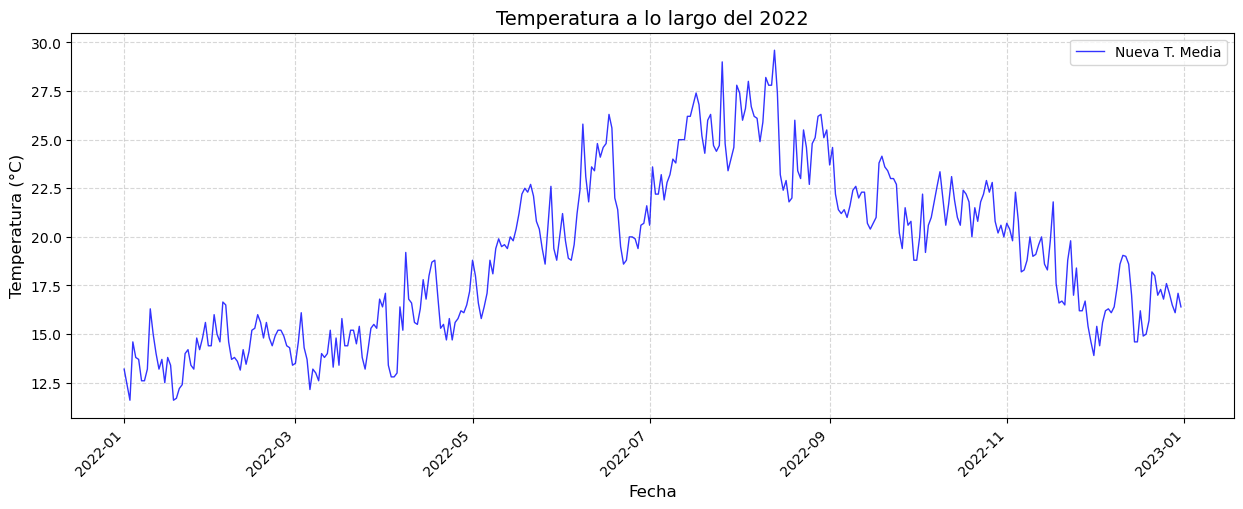

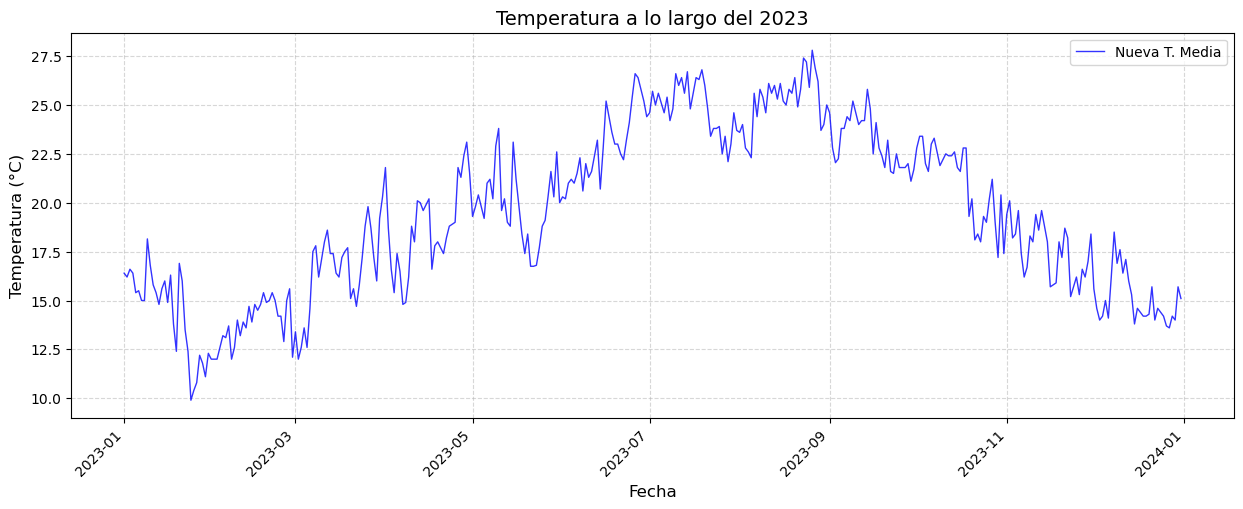

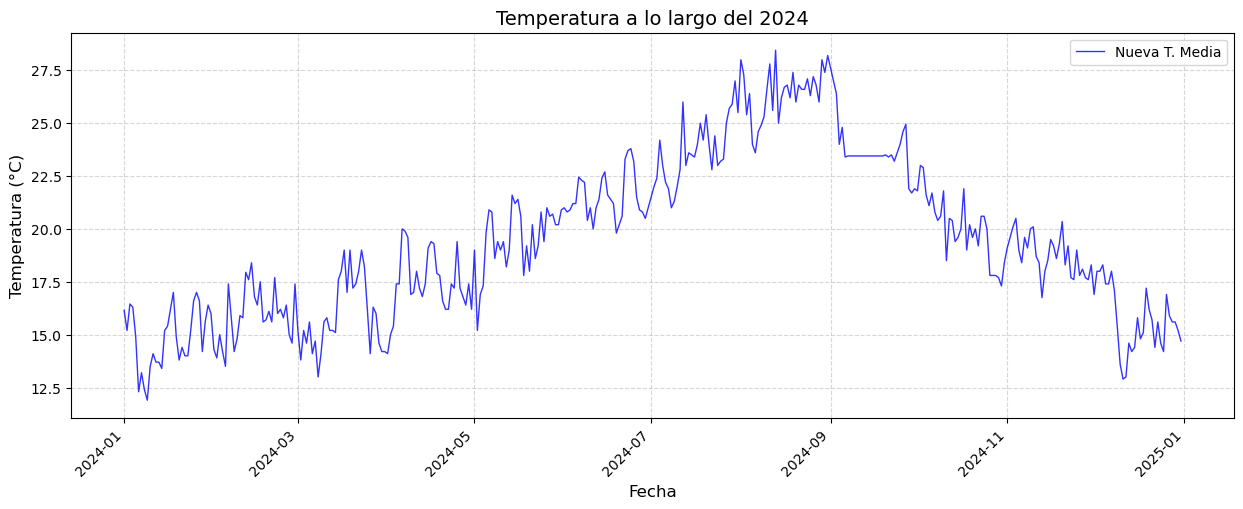

In [31]:
# Obtener los años únicos en el DataFrame
años_unicos = df_pandas['fecha'].dt.year.unique()

# Generar un gráfico por cada año
for año in años_unicos[:6]:
    df_anual = df_pandas[df_pandas['fecha'].dt.year == año]
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_anual['fecha'], df_anual['tmed_corrected'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='Nueva T. Media')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura a lo largo del {año}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.show()

In [32]:
df_pandas

,fecha,tmed,tmin,tmax,hrMedia,MA,lag_1,outlier_ma,outlier_hm,tmed_corrected
0,2019-01-01,13.9,9.6,18.200001,63.0,NaN,NaN,False,False,13.9
1,2019-01-02,14.6,9.4,19.900000,56.0,NaN,0.700001,False,False,14.6
2,2019-01-03,13.1,9.6,16.600000,70.0,NaN,-1.500000,False,False,13.1
3,2019-01-04,12.7,9.3,16.100000,69.0,NaN,-0.400001,False,False,12.7
4,2019-01-05,12.4,7.9,17.000000,67.0,NaN,-0.300000,False,False,12.4
...,...,...,...,...,...,...,...,...,...,...
2194,2025-01-03,13.9,9.5,18.299999,72.0,19.473562,0.099999,False,False,13.9
2195,2025-01-04,15.4,10.2,20.700001,41.0,19.474932,1.500000,False,False,15.4
2196,2025-01-05,14.2,11.0,17.400000,64.0,19.480137,-1.200000,False,False,14.2
2197,2025-01-06,15.5,12.0,19.000000,64.0,19.486438,1.300000,False,False,15.5


In [33]:
df_pandas["tmed"] = df_pandas["tmed_corrected"]

In [35]:
df_pandas.drop(columns=["MA", "lag_1", "outlier_ma", "outlier_hm", "tmed_corrected"], inplace=True)

In [36]:
df_pandas

,fecha,tmed,tmin,tmax,hrMedia
0,2019-01-01,13.9,9.6,18.200001,63.0
1,2019-01-02,14.6,9.4,19.900000,56.0
2,2019-01-03,13.1,9.6,16.600000,70.0
3,2019-01-04,12.7,9.3,16.100000,69.0
4,2019-01-05,12.4,7.9,17.000000,67.0
...,...,...,...,...,...
2194,2025-01-03,13.9,9.5,18.299999,72.0
2195,2025-01-04,15.4,10.2,20.700001,41.0
2196,2025-01-05,14.2,11.0,17.400000,64.0
2197,2025-01-06,15.5,12.0,19.000000,64.0


Ahora deberemos realizar el mismo estudio para las otras 3 variables que tendremos en consideracion para predecir

Ahora pasaremos a obtener nuevas columnas que aporten informacion al modelo para mejorar las predicciones

In [37]:
df = df_pandas.copy()

In [38]:
# Convertir la columna 'fecha' a tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Ordenar por fecha
df = df.sort_values('fecha')

# Verificar que no haya duplicados
df = df.drop_duplicates(subset=['fecha'])

##### Obtenemos los valores maximo, minimo y media historico para cada fecha 

In [39]:
# Crear columnas de estadísticas históricas
def calcular_estadisticas_diarias(df, columna):
    # Verifica si la columna existe en el DataFrame
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")

    # Calcula el máximo, mínimo y media diaria
    df[f'{columna}_max'] = df.groupby(df['fecha'].dt.dayofyear)[columna].transform('max')
    df[f'{columna}_min'] = df.groupby(df['fecha'].dt.dayofyear)[columna].transform('min')
    df[f'{columna}_mean'] = df.groupby(df['fecha'].dt.dayofyear)[columna].transform('mean')

    return df

In [40]:
# Lista de columnas para las cuales se calcularán las estadísticas
columnas = ['tmed', 'tmin', 'tmax', 'hrMedia']

# Bucle para aplicar la función a cada columna
for columna in columnas:
    df = calcular_estadisticas_diarias(df, columna)

##### Obtenemos la estacion del año para cada fecha

In [41]:
# Crear columna de estación del año
def get_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    elif month in [9, 10, 11]:
        return 'Otoño'

In [42]:
df['estacion'] = df['fecha'].dt.month.apply(get_season)

Aplicamos transformacion OHE (One Hot Encoding) para la utilizacion de esta informacion de cara al modelo

In [43]:
# Aplicar get_dummies
df = pd.get_dummies(df, columns=['estacion'])

In [44]:
# Crear columnas de día de la semana y mes
# df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month

In [45]:
# Crear columnas de diferencias y variaciones
# df['tmed_diff'] = df['tmed'].diff()
# df['tmed_rolling_mean'] = df['tmed'].rolling(window=7).mean()

In [46]:
df.head(5)

,fecha,tmed,tmin,tmax,hrMedia,tmed_max,tmed_min,tmed_mean,tmin_max,tmin_min,...,tmax_min,tmax_mean,hrMedia_max,hrMedia_min,hrMedia_mean,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,mes
0,2019-01-01,13.9,9.6,18.200001,63.0,16.400000,13.2,14.307143,14.1,9.6,...,15.9,18.000000,86.0,36.0,59.285714,True,False,False,False,1
1,2019-01-02,14.6,9.4,19.900000,56.0,16.200001,11.2,13.871429,12.6,6.1,...,15.2,17.800000,85.0,51.0,64.571429,True,False,False,False,1
2,2019-01-03,13.1,9.6,16.600000,70.0,16.600000,10.2,13.635714,13.1,5.3,...,14.2,17.528571,86.0,41.0,68.285714,True,False,False,False,1
3,2019-01-04,12.7,9.3,16.100000,69.0,16.400000,11.2,14.257143,14.0,5.6,...,16.1,18.342857,78.0,41.0,64.857143,True,False,False,False,1
4,2019-01-05,12.4,7.9,17.000000,67.0,15.400000,11.4,13.500000,12.9,7.7,...,15.0,16.800000,74.0,40.0,62.285714,True,False,False,False,1


In [47]:
df.columns

Index(['fecha', 'tmed', 'tmin', 'tmax', 'hrMedia', 'tmed_max', 'tmed_min',
       'tmed_mean', 'tmin_max', 'tmin_min', 'tmin_mean', 'tmax_max',
       'tmax_min', 'tmax_mean', 'hrMedia_max', 'hrMedia_min', 'hrMedia_mean',
       'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera',
       'estacion_Verano', 'mes'],
      dtype='object')

Guardamos el dataframe final preparado para pasar al entrenamiento del modelo

In [48]:
# Guardar el DataFrame limpio en un nuevo archivo CSV (opcional)
ruta_guardado = "/home/jovyan/work/data/homogeneized/df_marbella_daily.csv"
df.to_csv(ruta_guardado, index=False)

In [49]:
# Detener la sesión de Spark
spark.stop()